# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from utils import *
from numba import njit
from IPython import display
import pylab as pl
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(1569)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.6
N = 500000
NumberofSources = 4
NumberofMixtures = 8

M = NumberofMixtures
r = NumberofSources

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)
S = 2 * S - 1
INPUT_STD = 0.5
A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)
SNR=30

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.00238359335688


# Visualize Generated Sources and Mixtures

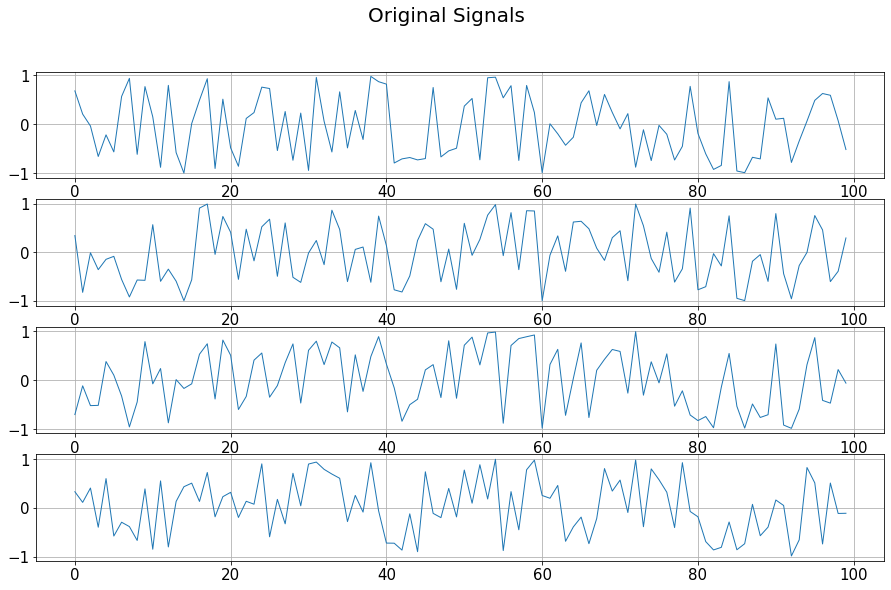

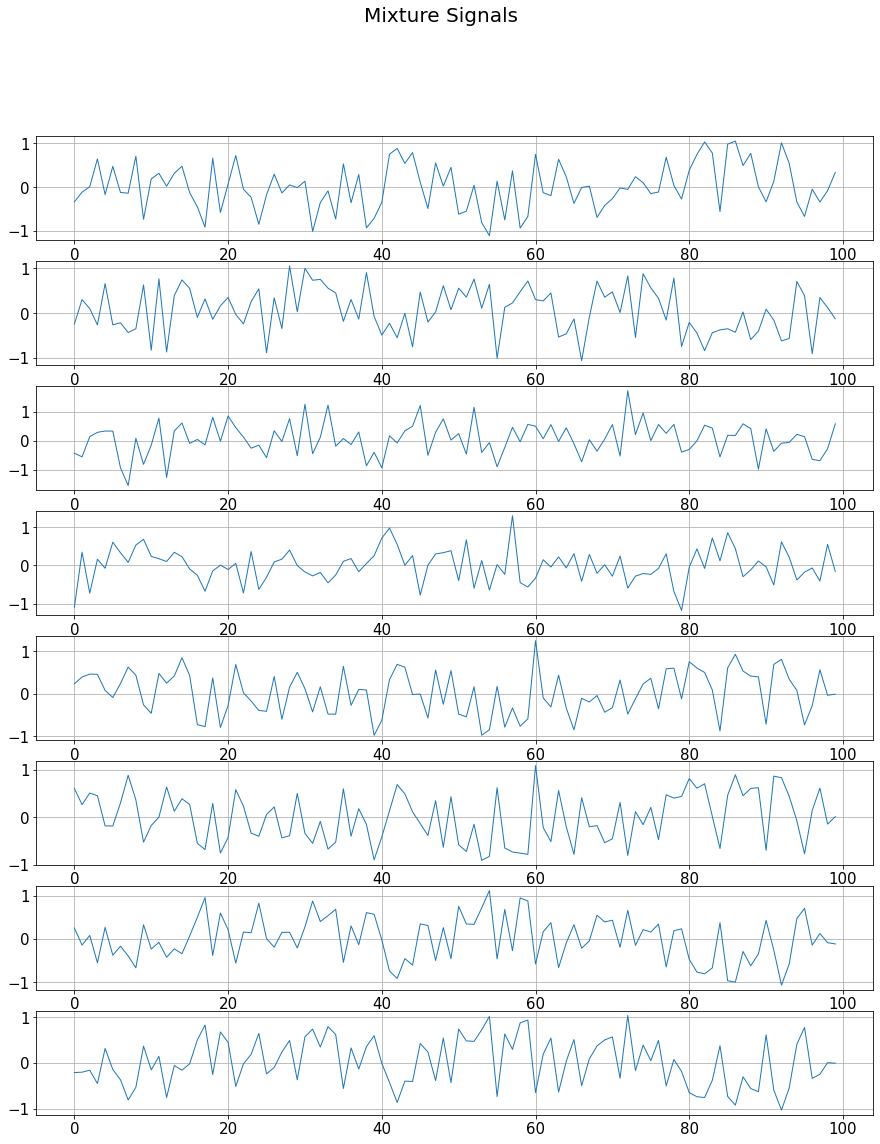

In [4]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
if rho > 0.4:
    MUS = 0.25
    gamma_stop = 5*1e-4
else:
    MUS = 0.6
    gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [0.2,0.2]
LayerMaximumGains = [1e6,5]
WScalings = [0.005,0.005]
GamScalings = [2,1]
zeta = 5*1e-5
beta = 0.5
muD = [1.125, 0.2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

In [6]:
debug_iteration_point = 25000
modelWSM = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                        gamma_start = MUS, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                        muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                        W_HX = W_HX, W_YH = W_YH,
                        DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                        LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                        set_ground_truth = True, S = S, A = A)

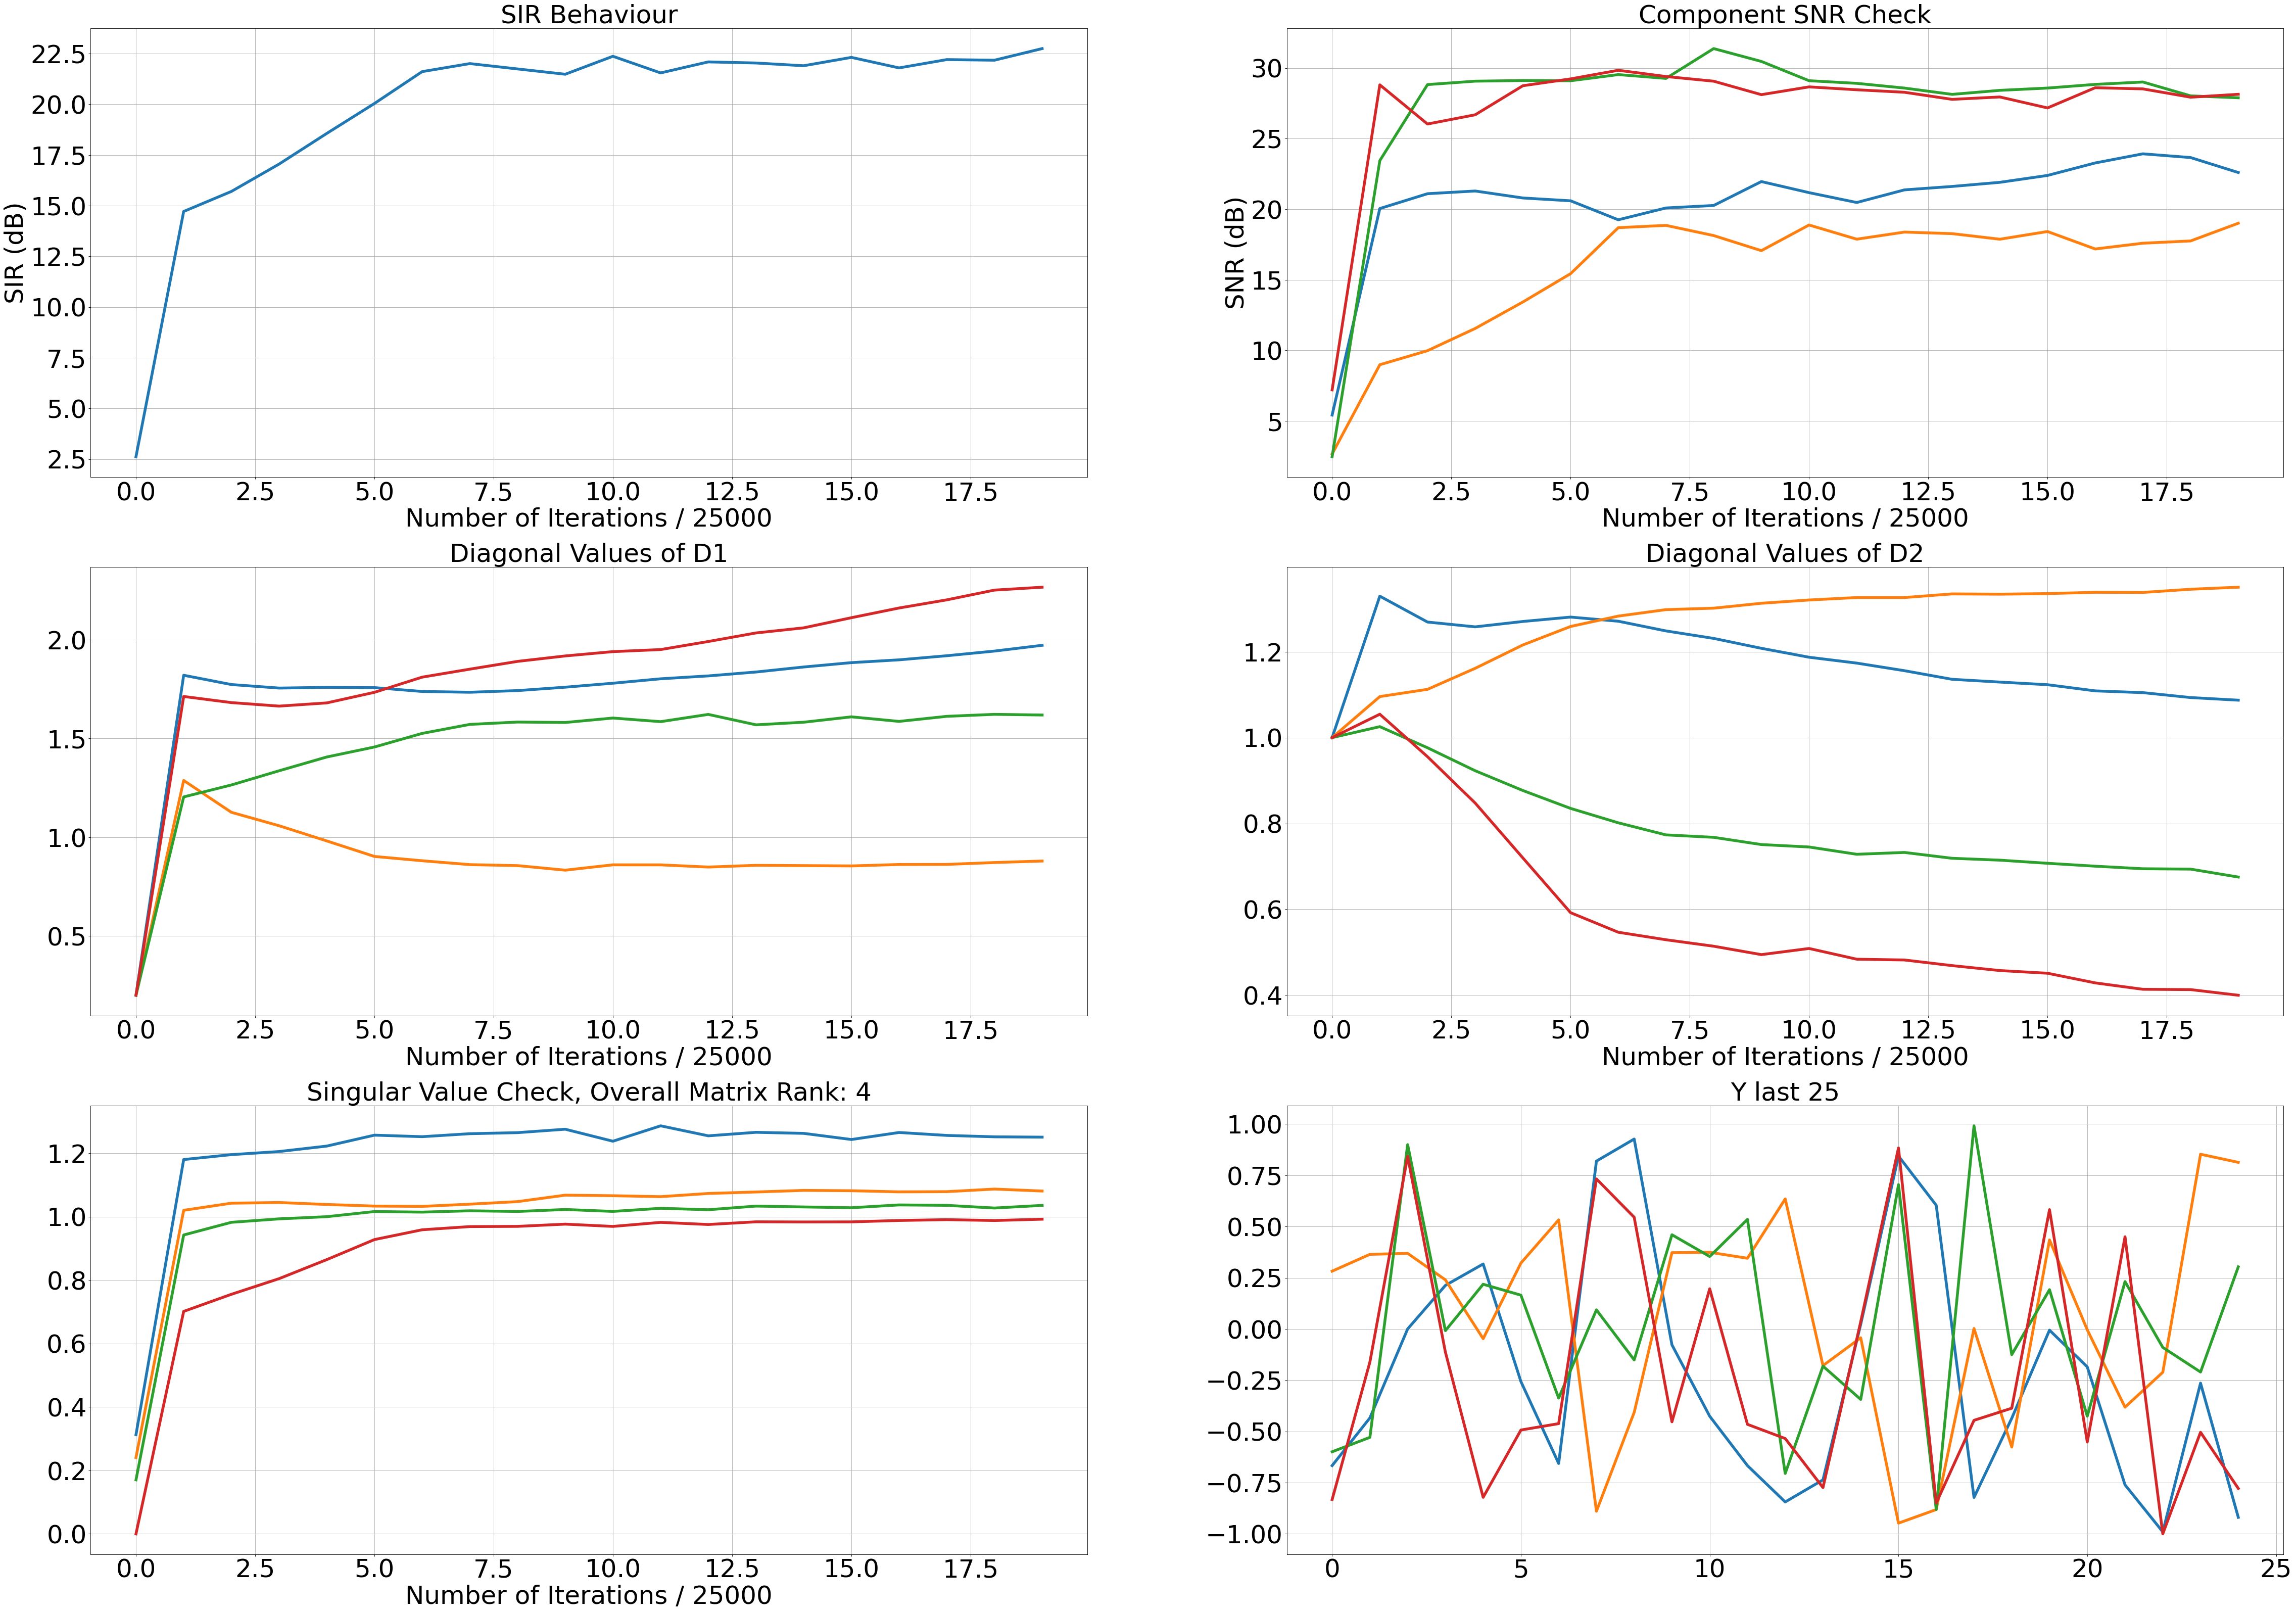

100%|██████████| 500000/500000 [07:17<00:00, 1143.94it/s]


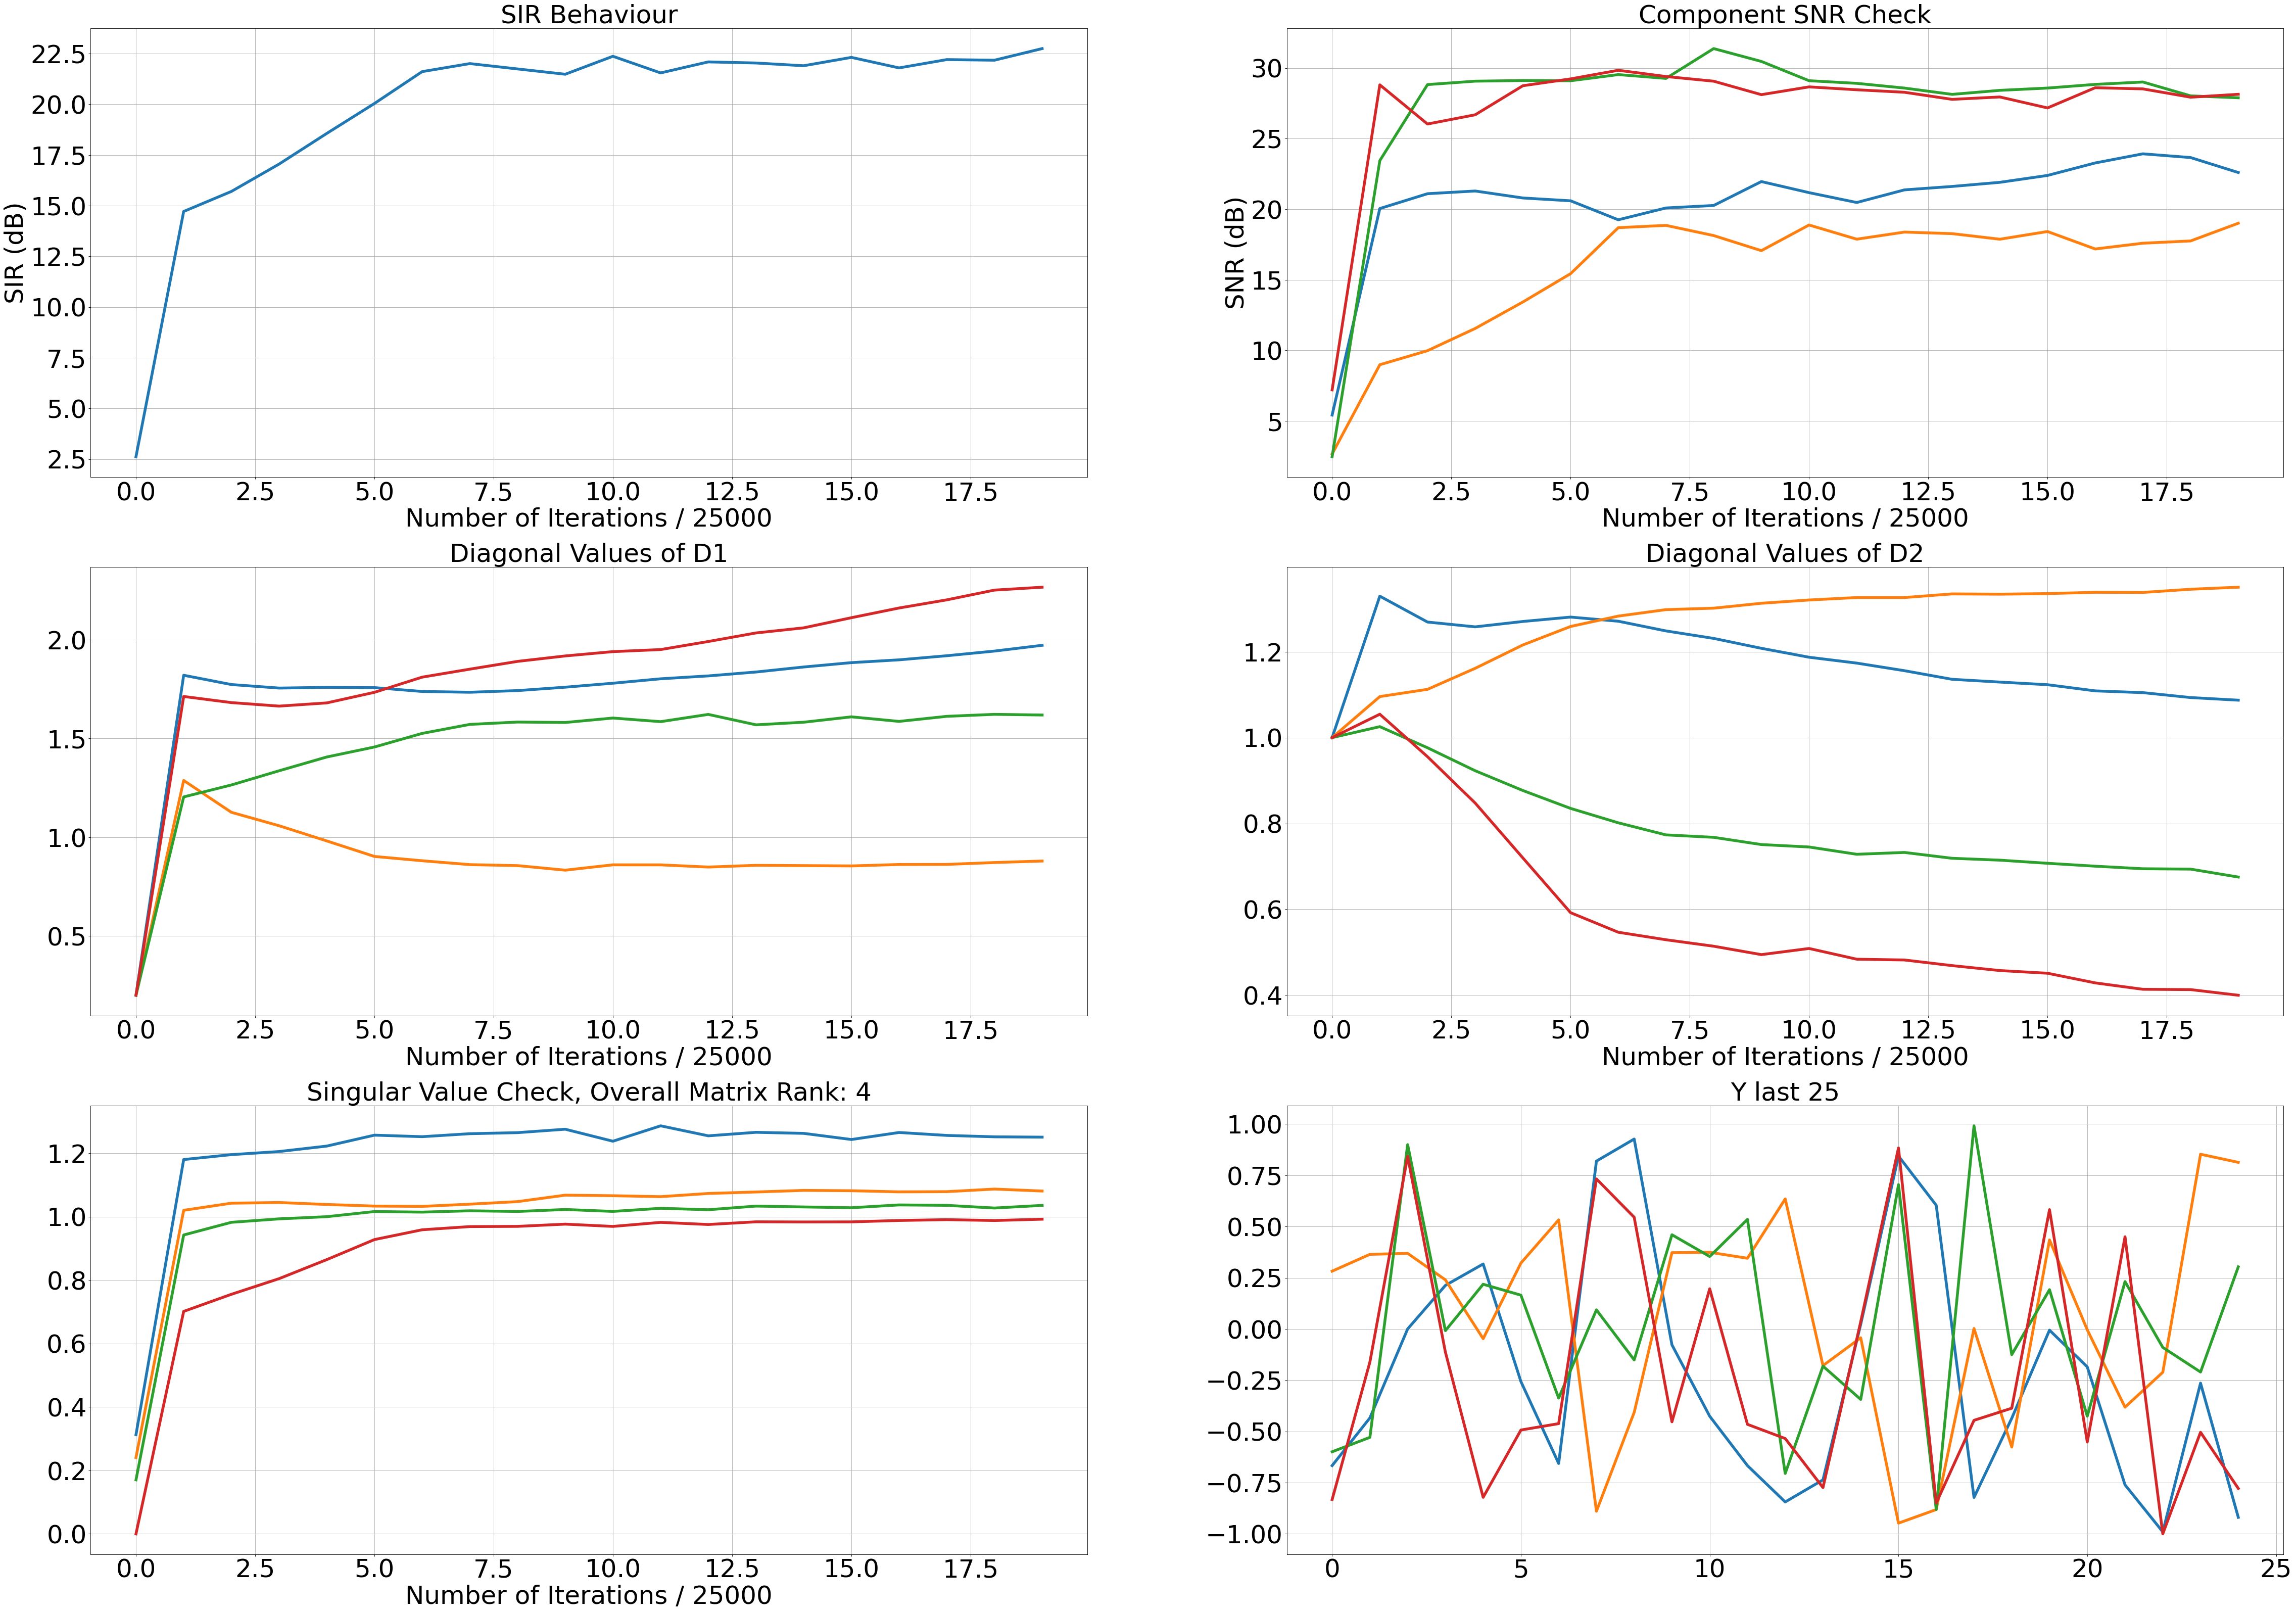

In [7]:
modelWSM.fit_batch_antisparse(  X, n_epochs = 1, 
                                neural_lr_start = 0.75,
                                neural_lr_stop = 0.05,
                                debug_iteration_point = debug_iteration_point,
                                plot_in_jupyter = True,
                              )

# Visualize SNR Convergence of Each Source Component

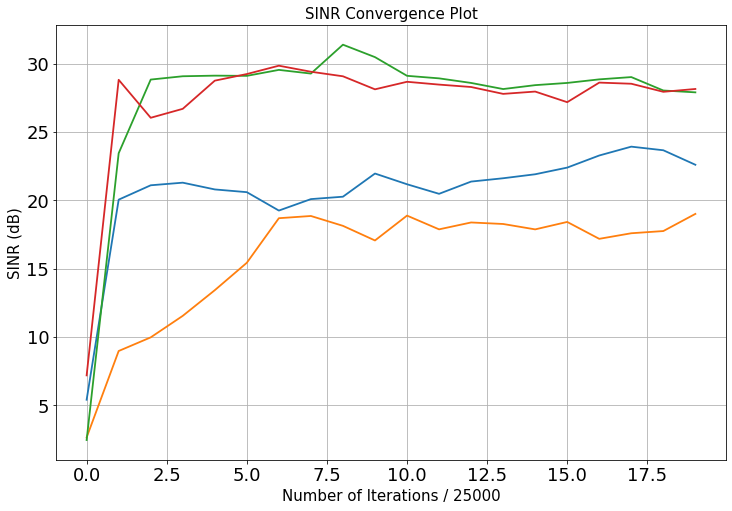

In [8]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [9]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [23.64751364 19.06528557 29.05517423 26.51530212]

Overall SINR : 22.964129807967964


# Vizualize Extracted Signals Compared to Original Sources

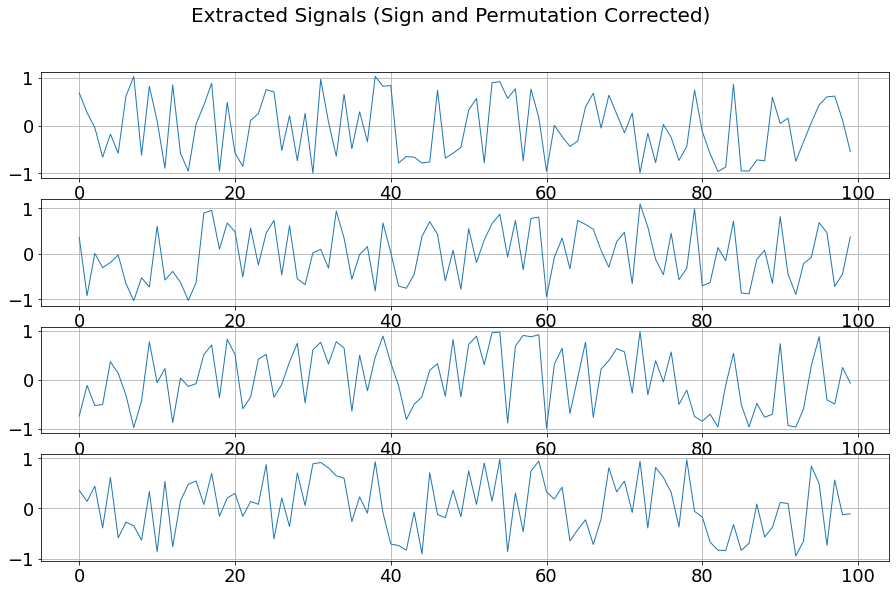

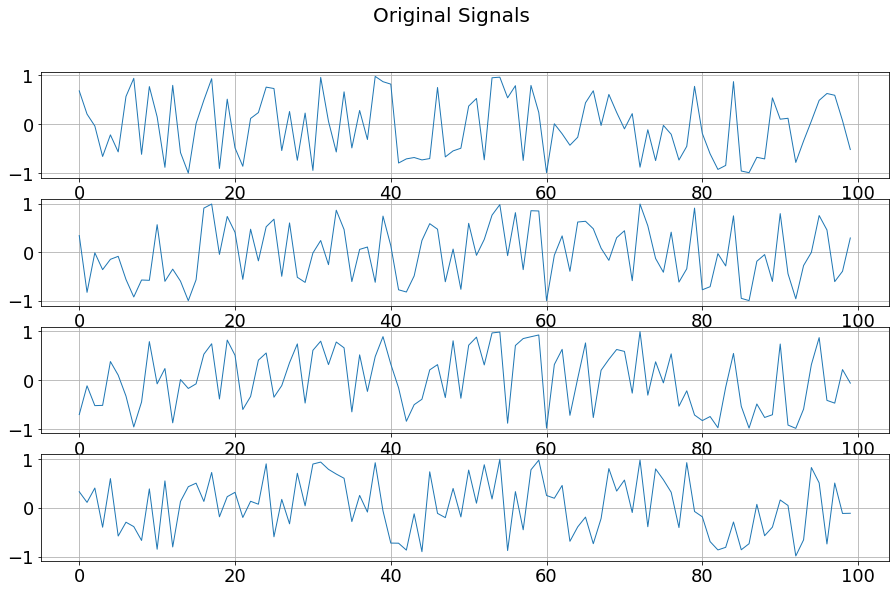

In [10]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)